In [16]:
import os
import time
import json
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter
from concurrent.futures import ThreadPoolExecutor, as_completed

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image, ImageDraw

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize

from torchvision.models import efficientnet_b2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import HTML, display

# Dataset Preparation

In [17]:
# Paths
root_path = os.path.join('..', 'dataset', 'malaria')
train_json_path = os.path.join(root_path, 'training.json')
test_json_path = os.path.join(root_path, 'test.json')
image_path = os.path.join(root_path, 'images')
print("Root Path:", root_path)
print("Train JSON Path:", train_json_path)
print("Test JSON Path:", test_json_path)
print("Image Path:", image_path)

Root Path: ..\dataset\malaria
Train JSON Path: ..\dataset\malaria\training.json
Test JSON Path: ..\dataset\malaria\test.json
Image Path: ..\dataset\malaria\images


In [18]:
models_dir = os.path.join('.', 'efficientnet_models') 
os.makedirs(models_dir, exist_ok=True) 

print(f"Models will be saved in: {models_dir}")

Models will be saved in: .\efficientnet_models


Counting Images

In [19]:
# Check if the image directory exists
if not os.path.exists(image_path):
    print(f"Error: The image path '{image_path}' does not exist.")
else:
    # Using defaultdict to simplify counting
    image_sizes = defaultdict(int)
    
    # Getting a list of all files in the directory
    image_files = os.listdir(image_path)
    
    # Iterating through the files and get the size of each image
    for filename in image_files:
        # Construct the full path to the image file
        full_path = os.path.join(image_path, filename)
        
        # Check if the file is a regular file and not a directory
        if os.path.isfile(full_path):
            try:
                # Open the image file using Pillow
                with Image.open(full_path) as img:
                    # Get the size (width, height) of the image
                    width, height = img.size
                    
                    # Increment the count for this specific size
                    image_sizes[(width, height)] += 1
            except Exception as e:
                # Handle cases where the file is not a valid image
                print(f"Could not open image file: {filename} - {e}")
    
    # Print the counts for each image size
    print("Image size counts:")
    for size, count in image_sizes.items():
        print(f"Size: {size[0]}x{size[1]}, Count: {count}")

Image size counts:
Size: 1600x1200, Count: 1208
Size: 1944x1383, Count: 120


Counting Json images

In [20]:
# Function to count entries in a JSON file
def count_json_entries(file_path):
    if not os.path.exists(file_path):
        print(f"Error: The file path '{file_path}' does not exist.")
        return 0
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Assuming the JSON data is a list of entries
    return len(data)

# Count entries in each file
train_count = count_json_entries(train_json_path)
test_count = count_json_entries(test_json_path)

# Print the results
print(f"Number of entries in training.json: {train_count}")
print(f"Number of entries in test.json: {test_count}")

Number of entries in training.json: 1208
Number of entries in test.json: 120


Visualizing data distribution

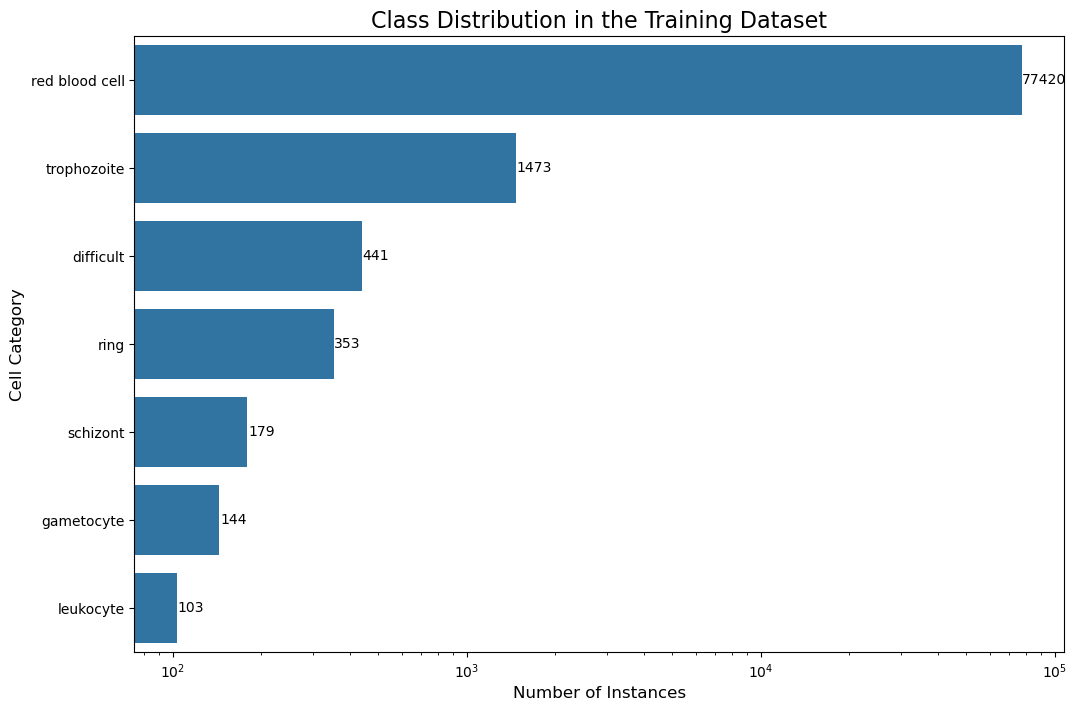

In [21]:
def ploting_cells_count(training_dataset_json):
  # Loading the JSON
  with open(training_dataset_json, 'r') as f:
      training_metadata = json.load(f)

  # Extracting all object categories into a list
  all_categories = []
  for item in training_metadata:
      for obj in item['objects']:
          all_categories.append(obj['category'])

  df = pd.DataFrame(all_categories, columns=['category'])

  # --- Plotting ---
  plt.figure(figsize=(12, 8))
  ax = sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
  plt.title('Class Distribution in the Training Dataset', fontsize=16)
  plt.xlabel('Number of Instances', fontsize=12)
  plt.ylabel('Cell Category', fontsize=12)
  # Use a log scale for the x-axis due to the large imbalance
  plt.xscale('log')

  for p in ax.patches:
      width = p.get_width()
      y = p.get_y() + p.get_height() / 2

      # Adding the text to the plot
      ax.text(width + 1,  # Positioning the text slightly to the right of the bar
              y,
              f'{int(width)}', # Displaying count
              ha='left',      # Horizontal alignment
              va='center')    # Vertical alignment
  plt.show()

ploting_cells_count(train_json_path)

## B. Deeplearning

In [22]:
class MalariaDataset(Dataset):
    def __init__(self, json_path, image_root, transform=None, category_map=None, image_size=128):
        with open(json_path, 'r') as f:
            self.entries = json.load(f)
        self.image_root = image_root
        self.transform = transform
        self.image_size = image_size 

        if category_map is None:
            all_categories = set()
            for item in self.entries:
                for obj in item['objects']:
                    all_categories.add(obj['category'])
            self.category_map = {cat: idx for idx, cat in enumerate(sorted(all_categories))}
        else:
            self.category_map = category_map
        
        # Store labels for each item, useful for sampling
        self.labels = []
        for item in self.entries:
            # We take the label of the first object for simplicity in sampling.
            # A more complex strategy could consider all objects.
            if item['objects']:
                cat = item['objects'][0]['category']
                self.labels.append(self.category_map[cat])
            else:
                # Handle images with no objects if necessary
                self.labels.append(-1) # Placeholder label

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        pathname_from_json = entry['image']['pathname']
        image_name = os.path.basename(pathname_from_json)
        image_full_path = os.path.join(self.image_root, image_name)
        
        try:
            image = Image.open(image_full_path).convert("RGB")
        except FileNotFoundError:
            print(f"Error: Image not found at {image_full_path}")
            # Use the stored image_size for the placeholder
            placeholder_img = torch.zeros((3, self.image_size, self.image_size)) # <-- FIX
            placeholder_target = {'boxes': torch.empty(0, 4), 'labels': torch.empty(0, dtype=torch.long)}
            return placeholder_img, placeholder_target

        boxes = []
        labels = []
        for obj in entry['objects']:
            bb = obj['bounding_box']
            boxes.append([bb['minimum']['c'], bb['minimum']['r'], bb['maximum']['c'], bb['maximum']['r']])
            labels.append(self.category_map[obj['category']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {'boxes': boxes, 'labels': labels}
        return image, target


### Sampler

In [23]:
# Utility function to create a sampler for handling class imbalance
def create_sampler(dataset):
    """Creates a WeightedRandomSampler to oversample minority classes."""
    # Count frequency of each class in the dataset
    class_counts = Counter(dataset.labels)
    
    # Remove placeholder labels if any
    if -1 in class_counts:
        del class_counts[-1]
        
    print("Class distribution:", class_counts)

    # Calculate weight for each class (more weight to rare classes)
    num_samples = len(dataset.labels)
    class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
    
    # Assign a weight to each sample in the dataset
    sample_weights = [class_weights.get(label, 0) for label in dataset.labels]

    # Create the sampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler


### 1. Effecientnetb1

In [24]:
class EfficientNetDetector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = efficientnet_b2(weights='IMAGENET1K_V1')
        # Replace the final fully connected layer
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity() # Remove the original classifier

        # New heads for your task
        self.classifier = nn.Linear(num_features, num_classes)
        self.bbox_head = nn.Linear(num_features, 4)

    def forward(self, x):
        features = self.backbone(x)
        class_scores = self.classifier(features)
        bbox_preds = self.bbox_head(features)
        return class_scores, bbox_preds

In [25]:
# Your loss functions and collate_fn here...
def margin_loss(class_scores, targets, margin=0.2):
    one_hot_targets = F.one_hot(targets.long(), num_classes=class_scores.size(-1)).float()
    left = F.relu(margin - class_scores) * one_hot_targets
    right = F.relu(class_scores - (1 - margin)) * (1.0 - one_hot_targets)
    return (left + right).sum(dim=-1).mean()

def bbox_loss(preds, targets):
    if preds.dim() == 1:
        preds = preds.unsqueeze(0)
    num_preds, num_targets = preds.size(0), targets.size(0)
    if num_preds > num_targets:
        padding = torch.zeros((num_preds - num_targets, 4), device=targets.device)
        targets = torch.cat([targets, padding], dim=0)
    elif num_targets > num_preds:
        padding = torch.zeros((num_targets - num_preds, 4), device=preds.device)
        preds = torch.cat([preds, padding], dim=0)
    return F.smooth_l1_loss(preds, targets)

def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets


In [26]:
# Your train and validate functions here...
def train_model(model, train_loader, optimizer, epoch, device, image_size):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Training Epoch {epoch}", unit="batch")
    for images, targets_list in pbar:
        images = images.to(device)
        optimizer.zero_grad()

        class_scores, bbox_preds = model(images)
        
        batch_class_loss = 0
        batch_bbox_loss = 0
        
        for i in range(images.size(0)):
            target = targets_list[i]
            target_boxes = target['boxes'].to(device)
            target_labels = target['labels'].to(device)
            
            if len(target_labels) == 0: continue
            
            # Normalize bounding boxes
            target_boxes_norm = target_boxes / torch.tensor([image_size, image_size, image_size, image_size], device=device) # <-- NEW

            batch_class_loss += margin_loss(class_scores[i].unsqueeze(0), target_labels)
            batch_bbox_loss += bbox_loss(bbox_preds[i], target_boxes_norm)

            predicted = torch.argmax(class_scores[i])
            correct += (predicted == target_labels).sum().item()
            total += len(target_labels)
        
        loss = batch_class_loss + 0.1 * batch_bbox_loss
        if total > 0:
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Train Epoch: {epoch}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return epoch_loss, accuracy

def validate_model(model, val_loader, device, image_size): # <-- MODIFIED
    all_labels = []
    all_preds = []
    all_scores = []
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, targets_list in tqdm(val_loader, desc="Validating", unit="batch"):
            images = images.to(device)
            class_scores, bbox_preds = model(images)

            for i in range(images.size(0)):
                target = targets_list[i]
                target_boxes = target['boxes'].to(device)
                target_labels = target['labels'].to(device)
                
                if len(target_labels) == 0: continue
                
                target_boxes_norm = target_boxes / torch.tensor([image_size, image_size, image_size, image_size], device=device) # <-- NEW

                loss = margin_loss(class_scores[i].unsqueeze(0), target_labels) + \
                       0.1 * bbox_loss(bbox_preds[i], target_boxes_norm)
                running_loss += loss.item()
                
                predicted = torch.argmax(class_scores[i])
                correct += (predicted == target_labels).sum().item()
                total += len(target_labels)

    epoch_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return epoch_loss, accuracy



In [27]:
def run_experiment(params):
    """
    Runs a full training and validation experiment for a given set of hyperparameters.
    """
    print("\n" + "="*50)
    print(f"Params: {params}")
    print("="*50)

    # <-- NEW: Start the timer
    start_time = time.time()

    # --- 1. Setup Device and Create Transforms based on params ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_size = params['image_size'] # <-- NEW: Get image size from params

    # <-- MODIFIED: Use the image_size variable
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # --- 2. Create Datasets and DataLoaders ---
    train_ds = MalariaDataset(train_json_path, image_path, transform=train_transform, image_size=image_size)
    test_ds = MalariaDataset(test_json_path, image_path, transform=test_transform, category_map=train_ds.category_map, image_size=image_size)

    sampler = None
    shuffle = True
    if params['sampling'] == 'oversample':
        print("Applying weighted oversampling...")
        sampler = create_sampler(train_ds)
        shuffle = False

    train_loader = DataLoader(
        train_ds, batch_size=params['batch_size'], shuffle=shuffle, sampler=sampler,
        collate_fn=custom_collate_fn, num_workers=0
    )
    val_loader = DataLoader(
        test_ds, batch_size=params['batch_size'], shuffle=False,
        collate_fn=custom_collate_fn, num_workers=0
    )

    # --- 3. Initialize Model and Optimizer ---
    model = EfficientNetDetector(num_classes=len(train_ds.category_map)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['lr']) if params['optimizer'] == 'Adam' \
        else optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9)

    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    # --- 4. Training Loop ---
    best_val_accuracy = 0.0
    num_epochs = 10

    for epoch in range(1, num_epochs + 1):
        # Pass image_size to your train/validate functions if they need it for normalization
        train_loss, train_acc = train_model(model, train_loader, optimizer, epoch, device, image_size)
        val_loss, val_accuracy = validate_model(model, val_loader, device, image_size)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            print(f"New best model! Val Accuracy: {best_val_accuracy:.2f}%")

            # --- 5. Save the best model for this experiment ---
            model_filename = (f"model_lr_{params['lr']}_optim_{params['optimizer']}_"
                              f"sampling_{params['sampling']}_size_{params['image_size']}.pth")
            save_path = os.path.join(models_dir, model_filename)

            torch.save({
                'model_state_dict': model.state_dict(),
                'best_val_accuracy': best_val_accuracy,
                'params': params
            }, save_path)
            print(f"Model saved to {save_path}")

    # <-- NEW: Calculate total time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Finished experiment. Best validation accuracy: {best_val_accuracy:.2f}%")
    print(f"Total training time: {elapsed_time / 60:.2f} minutes")

    return {
        'params': params,
        'best_accuracy': best_val_accuracy,
        'training_time_minutes': elapsed_time / 60,
        'history': history 
    }

In [28]:
# --- Helper function to manage results ---
def get_completed_experiments(results_path):
    """Loads existing results and returns a set of completed parameter combos."""
    if not os.path.exists(results_path):
        return set(), []
    
    with open(results_path, 'r') as f:
        try:
            existing_results = json.load(f)
        except json.JSONDecodeError:
            return set(), [] # File is empty or corrupt

    # Create a unique, hashable representation of each param dictionary
    completed = set(tuple(sorted(res['params'].items())) for res in existing_results)
    print(f"Found {len(completed)} completed experiments in {results_path}.")
    return completed, existing_results

In [29]:
if __name__ == '__main__':
    # Define the grid of hyperparameters to search
    param_grid = {
        'lr': [0.001, 0.0001],
        'optimizer': ['Adam', 'SGD'],
        'batch_size': [32],
        'sampling': ['none', 'oversample'],
        'image_size': [128, 224] # <-- EXPERIMENT WITH SIZES
    }
    results_path = os.path.join(models_dir, 'grid_search_results.json')
    
    # --- 2. Generate all experiment configurations ---
    keys, values = zip(*param_grid.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    # --- 3. Load previous progress (CHECKPOINTING) ---
    completed_params, all_results = get_completed_experiments(results_path)
    
    print(f"Starting Grid Search. Total experiments to run: {len(experiments)}")
 # --- 4. Run the experiments ---
    for i, params in enumerate(experiments):
        # Create a unique key for the current parameter set
        current_param_key = tuple(sorted(params.items()))

        # Check if this experiment has already been completed
        if current_param_key in completed_params:
            print(f"\n--- Skipping Experiment {i+1}/{len(experiments)} (already done) ---")
            print(f"Params: {params}")
            continue

        # If not skipped, run the experiment
        print(f"\n--- Running Experiment {i+1}/{len(experiments)} ---")
        result = run_experiment(params)
        all_results.append(result)

        # --- 5. Save progress after EACH experiment (CHECKPOINTING) ---
        try:
            with open(results_path, 'w') as f:
                json.dump(all_results, f, indent=4)
            print(f"Progress saved to {results_path}")
        except Exception as e:
            print(f"Error saving progress: {e}")


    # --- 6. Print and save final results ---
    print("\n\n" + "#"*30)
    print("GRID SEARCH COMPLETE")
    print("#"*30)
    
    sorted_results = sorted(all_results, key=lambda x: x.get('best_accuracy', 0), reverse=True)
    
    for res in sorted_results:
        print(f"Acc: {res.get('best_accuracy', 0):.2f}% | "
            f"Time: {res.get('training_time_minutes', 0):.2f} min | "
            f"Params: {res.get('params', {})}")

    print(f"\nAll results saved to {results_path}")

Found 16 completed experiments in .\efficientnet_models\grid_search_results.json.
Starting Grid Search. Total experiments to run: 16

--- Skipping Experiment 1/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'none', 'image_size': 128}

--- Skipping Experiment 2/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'none', 'image_size': 224}

--- Skipping Experiment 3/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 128}

--- Skipping Experiment 4/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 224}

--- Skipping Experiment 5/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 'sampling': 'none', 'image_size': 128}

--- Skipping Experiment 6/16 (already done) ---
Params: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32, 's



########################################
Visualizing Training History of Best Model
Best Parameters: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 128}
Best Validation Accuracy: 94.80%
########################################


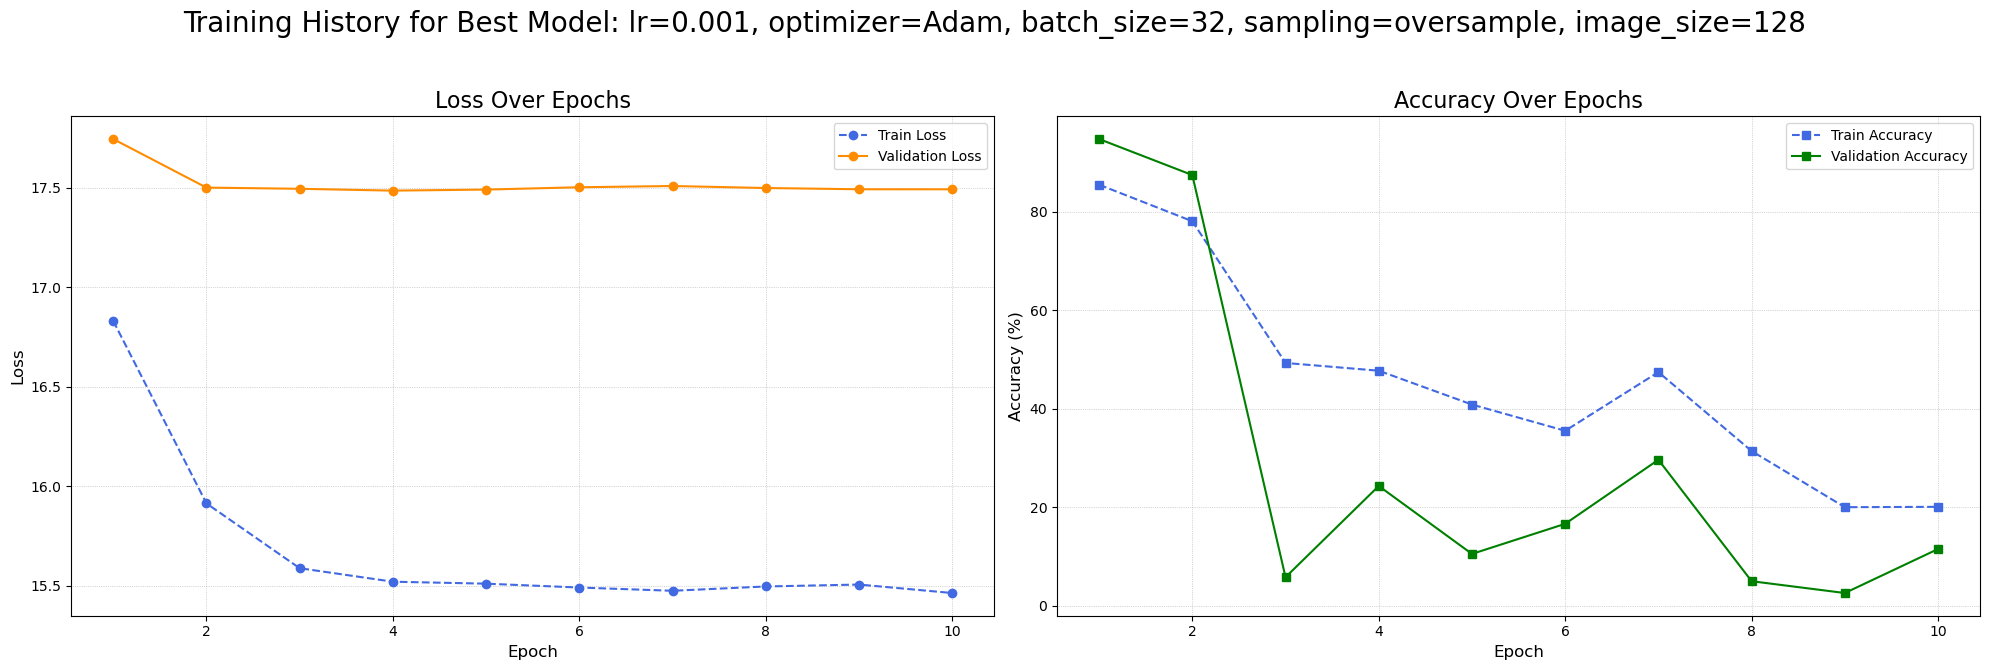

In [30]:
import matplotlib.pyplot as plt

def plot_training_history(history, params):
    """
    Plots the training and validation loss and accuracy curves from a history dictionary.
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Plot 1: Loss vs. Epochs ---
    ax[0].plot(epochs, history['train_loss'], label='Train Loss', color='royalblue', marker='o', linestyle='--')
    ax[0].plot(epochs, history['val_loss'], label='Validation Loss', color='darkorange', marker='o')
    ax[0].set_title('Loss Over Epochs', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=12)
    ax[0].set_ylabel('Loss', fontsize=12)
    ax[0].legend()
    ax[0].grid(True, which='both', linestyle=':', linewidth=0.5)

    # --- Plot 2: Accuracy vs. Epochs ---
    ax[1].plot(epochs, history['train_accuracy'], label='Train Accuracy', color='royalblue', marker='s', linestyle='--')
    ax[1].plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='green', marker='s')
    ax[1].set_title('Accuracy Over Epochs', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=12)
    ax[1].set_ylabel('Accuracy (%)', fontsize=12)
    ax[1].legend()
    ax[1].grid(True, which='both', linestyle=':', linewidth=0.5)

    param_str = ', '.join([f'{k}={v}' for k, v in params.items()])
    fig.suptitle(f'Training History for Best Model: {param_str}', fontsize=20)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- At the end of your `if __name__ == '__main__':` block, add this: ---

# Find the single best result from all experiments
if sorted_results:
    best_experiment_result = sorted_results[0]
    
    print("\n\n" + "#"*40)
    print("Visualizing Training History of Best Model")
    print(f"Best Parameters: {best_experiment_result['params']}")
    print(f"Best Validation Accuracy: {best_experiment_result['best_accuracy']:.2f}%")
    print("#"*40)

    # Plot its history
    plot_training_history(best_experiment_result['history'], best_experiment_result['params'])
else:
    print("No results to plot.")

## Gradcam

In [31]:
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import classification_report, confusion_matrix

# Helper function to un-normalize and display an image
def unnormalize_image(tensor_img):
    """Un-normalizes a tensor image for display."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # Permute the dimensions from (C, H, W) to (H, W, C)
    img = tensor_img.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

In [39]:
# REVISED validation function to correctly handle multi-object images
def validate_model(model, val_loader, device, image_size):
    model.eval()
    all_labels, all_preds = [], []
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, targets_list in tqdm(val_loader, desc="Validating", unit="batch"):
            images = images.to(device)
            class_scores, bbox_preds = model(images)

            for i in range(images.size(0)):
                target = targets_list[i]
                target_boxes = target['boxes'].to(device)
                target_labels = target['labels'].to(device)

                if len(target_labels) == 0: continue

                # Get the single predicted label for the entire image
                predicted_label_for_image = torch.argmax(class_scores[i]).cpu().item()

                # **FIX**: Iterate through ALL ground truth labels in the image
                # and pair each one with the single image-level prediction.
                for true_label in target_labels:
                    all_labels.append(true_label.cpu().item())
                    all_preds.append(predicted_label_for_image)

                # --- Loss and Accuracy Calculation (as before) ---
                target_boxes_norm = target_boxes / torch.tensor([image_size, image_size, image_size, image_size], device=device)
                loss = margin_loss(class_scores[i].unsqueeze(0), target_labels) + \
                       0.1 * bbox_loss(bbox_preds[i], target_boxes_norm)
                running_loss += loss.item()
                predicted = torch.argmax(class_scores[i])
                correct += (predicted == target_labels).sum().item() # This accuracy metric is still tricky in multi-label cases
                total += len(target_labels)

    epoch_loss = running_loss / len(val_loader)
    # Note: Accuracy might not be the best metric here, the classification report is more insightful.
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return epoch_loss, accuracy, all_labels, all_preds

In [40]:
def generate_validation_report(all_labels, all_preds, category_map):
    """Generates and displays a classification report and confusion matrix."""
    class_names = list(category_map.keys())
    # Define the full list of possible class indices
    label_indices = list(category_map.values())

    print("\\n" + "="*50)
    print("Classification Report")
    print("="*50)
    
    # **FIX**: Added the 'labels' parameter to tell the function about all possible classes.
    # Added 'zero_division=0' to prevent errors if a class isn't in the provided labels.
    print(classification_report(
        all_labels, 
        all_preds, 
        labels=label_indices, 
        target_names=class_names, 
        zero_division=0
    ))

    print("\\n" + "="*50)
    print("Confusion Matrix")
    print("="*50)
    
    # **FIX**: Added the 'labels' parameter here as well to ensure the matrix has the correct size.
    cm = confusion_matrix(all_labels, all_preds, labels=label_indices)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [41]:
def visualize_grad_cam(model, loader, device, category_map, num_images=5):
    """Generates and displays Grad-CAM visualizations."""
    # Define the target layer for Grad-CAM
    target_layers = [model.backbone.features[-1]]

    # Initialize Grad-CAM
    # **FIX**: Removed the deprecated 'use_cuda' argument.
    # The library now automatically detects the device from the model.
    cam = GradCAM(model=model, target_layers=target_layers)

    print("\\n" + "="*50)
    print(f"Generating Grad-CAM for {num_images} images...")
    print("="*50)

    # Invert category map to get names from indices
    idx_to_cat = {v: k for k, v in category_map.items()}

    model.eval()
    for i, (images, targets) in enumerate(loader):
        if i >= num_images:
            break

        input_tensor = images.to(device)
        target_info = targets[0] # Visualize for the first image in the batch

        # Get model prediction
        class_scores, bbox_preds = model(input_tensor[0].unsqueeze(0))
        pred_class_idx = class_scores.argmax().item()
        pred_class_name = idx_to_cat[pred_class_idx]

        # Get ground truth
        gt_class_idx = target_info['labels'][0].item()
        gt_class_name = idx_to_cat[gt_class_idx]
        gt_box = target_info['boxes'][0].numpy().astype(int)

        # Define the target for Grad-CAM (the predicted class)
        targets_for_cam = [ClassifierOutputTarget(pred_class_idx)]

        # Generate the CAM
        grayscale_cam = cam(input_tensor=input_tensor[0].unsqueeze(0), targets=targets_for_cam)
        grayscale_cam = grayscale_cam[0, :]

        # Un-normalize the image and overlay the heatmap
        img_np = unnormalize_image(input_tensor[0])
        cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

        # Draw ground truth bounding box on the original image
        img_with_box = (img_np * 255).astype(np.uint8).copy()
        cv2.rectangle(img_with_box, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (0, 255, 0), 2) # Green for GT

        # --- Plotting ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(img_with_box)
        ax1.set_title(f"Ground Truth: {gt_class_name}\\n(Box in Green)")
        ax1.axis('off')

        ax2.imshow(cam_image)
        ax2.set_title(f"Grad-CAM - Prediction: {pred_class_name}")
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

Loading Best Model with Params: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32, 'sampling': 'oversample', 'image_size': 128}
Best Validation Accuracy: 94.80%


C:\Users\shera\AppData\Local\Temp\ipykernel_21648\3743129664.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path)
Validating: 100%|███████

Validation Loss: 17.7447, Accuracy: 94.80%
\n==================================================
Classification Report
                precision    recall  f1-score   support

     difficult       0.00      0.00      0.00         5
    gametocyte       0.00      0.00      0.00        12
     leukocyte       0.00      0.00      0.00         0
red blood cell       0.95      1.00      0.97      5614
          ring       0.00      0.00      0.00       169
      schizont       0.00      0.00      0.00        11
   trophozoite       0.00      0.00      0.00       111

      accuracy                           0.95      5922
     macro avg       0.14      0.14      0.14      5922
  weighted avg       0.90      0.95      0.92      5922

\n==================================================
Confusion Matrix


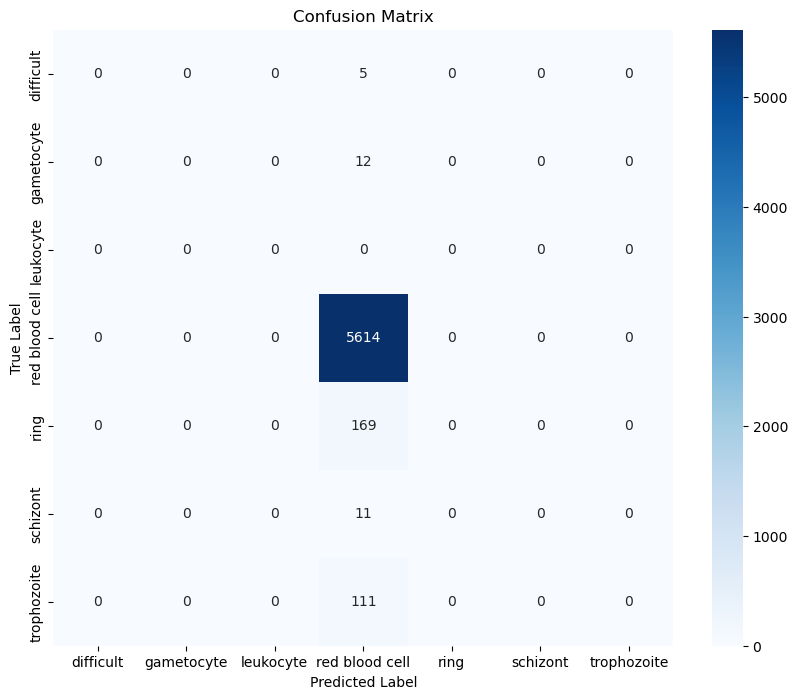

\n==================================================
Generating Grad-CAM for 5 images...


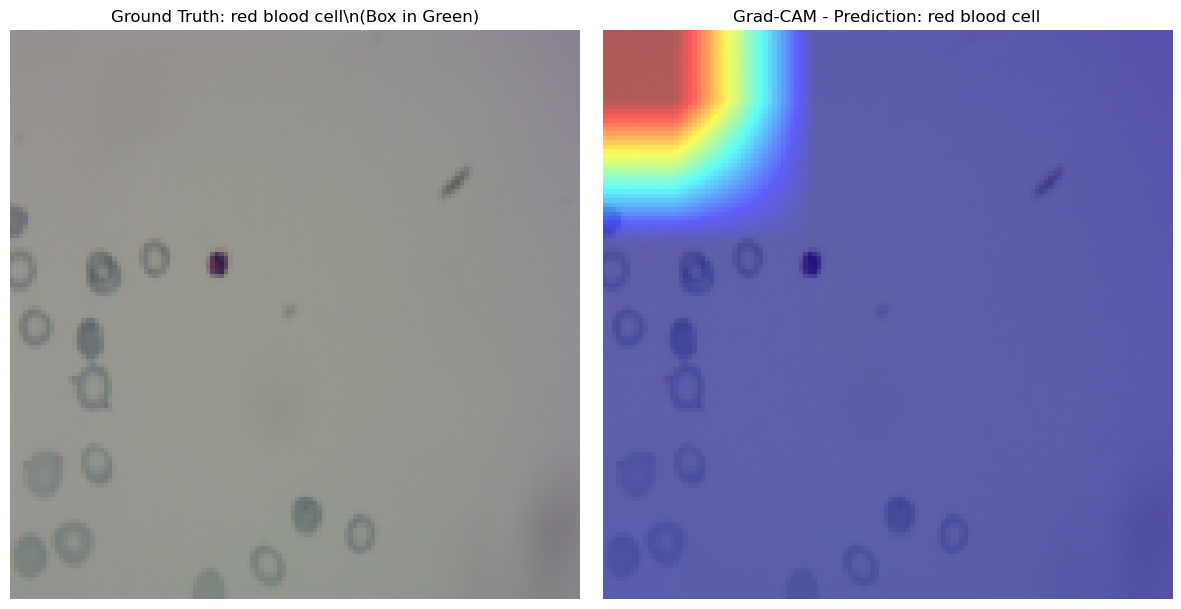

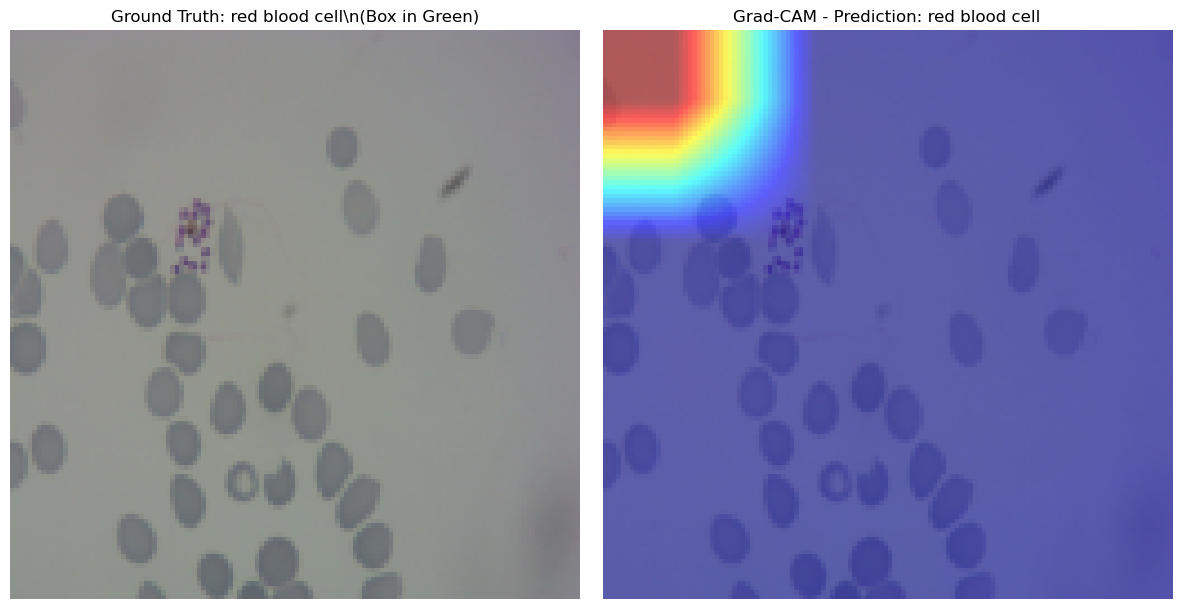

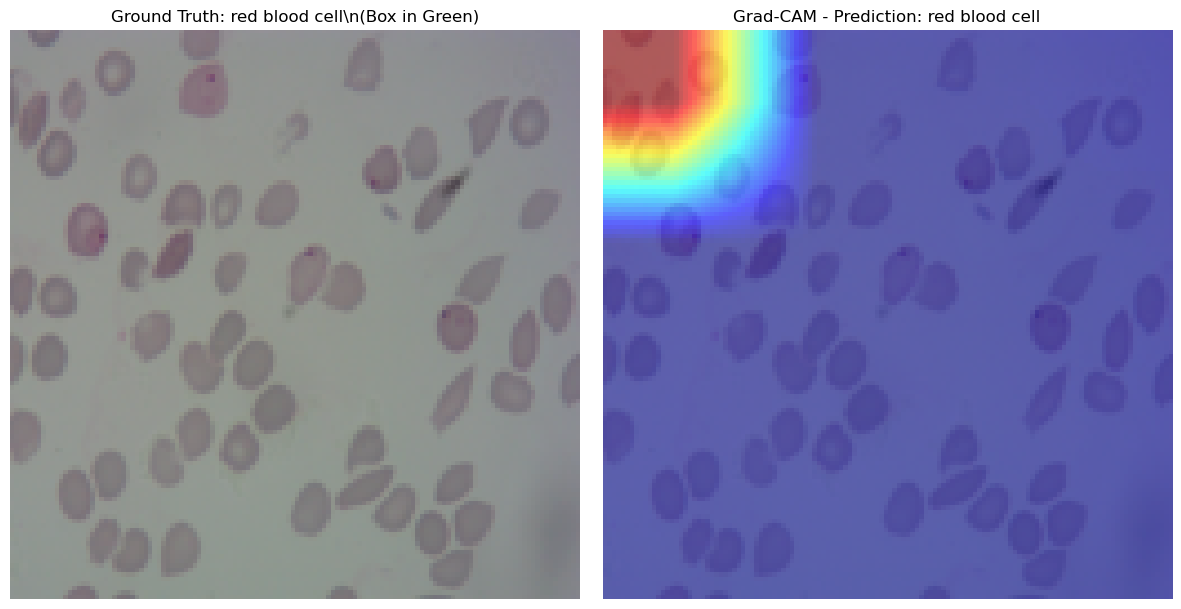

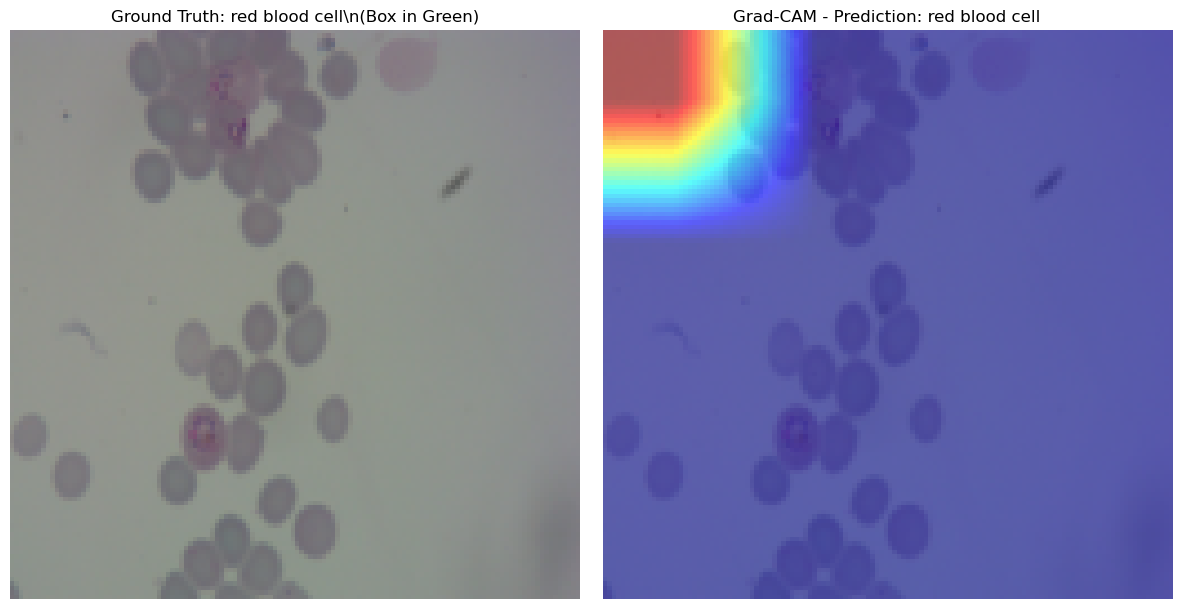

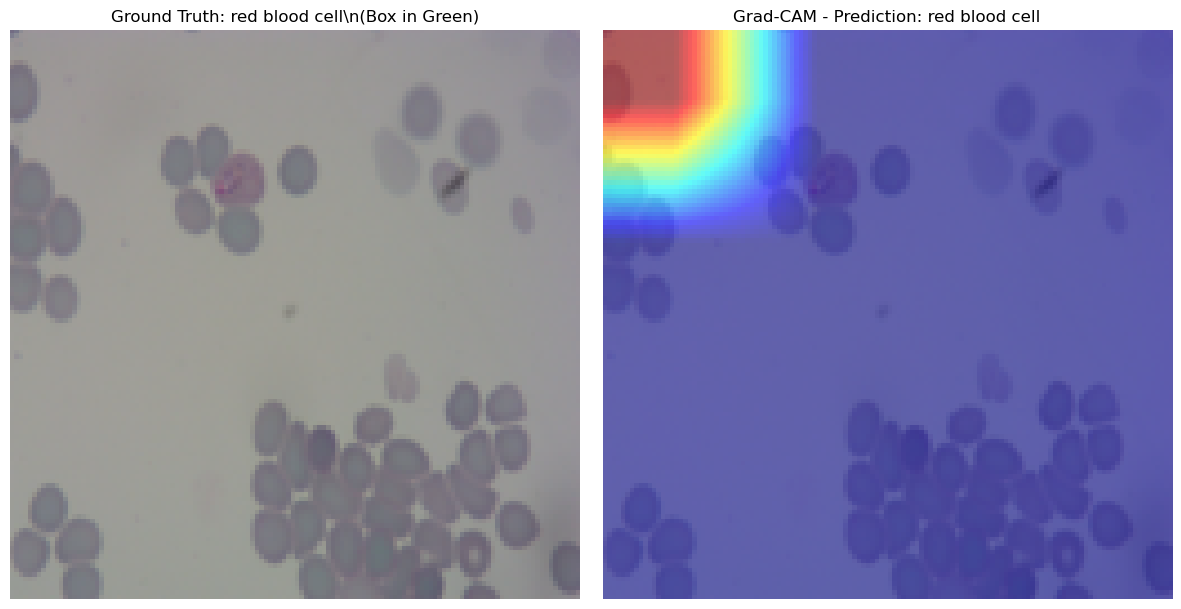

In [42]:

# --- Load the results and find the best model ---
results_path = os.path.join(models_dir, 'grid_search_results.json')
with open(results_path, 'r') as f:
    all_results = json.load(f)

sorted_results = sorted(all_results, key=lambda x: x.get('best_accuracy', 0), reverse=True)

if not sorted_results:
    print("No completed experiments found. Please run the training first.")
else:
    best_result = sorted_results[0]
    params = best_result['params']
    print("="*50)
    print(f"Loading Best Model with Params: {params}")
    print(f"Best Validation Accuracy: {best_result['best_accuracy']:.2f}%")
    print("="*50)

    # --- Setup device, transforms, and dataloaders for the best model ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_size = params['image_size']
    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # We need a train_ds just to get the category_map, no training needed
    train_ds_for_map = MalariaDataset(train_json_path, image_path)
    test_ds = MalariaDataset(test_json_path, image_path, transform=test_transform, category_map=train_ds_for_map.category_map, image_size=image_size)
    val_loader = DataLoader(test_ds, batch_size=params['batch_size'], shuffle=False, collate_fn=custom_collate_fn)
    # Create a separate loader for CAM with batch_size=1 and shuffle=True to get diverse images
    cam_loader = DataLoader(test_ds, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)


    # --- Load the model's state dictionary ---
    model = EfficientNetDetector(num_classes=len(train_ds_for_map.category_map)).to(device)
    model_filename = (f"model_lr_{params['lr']}_optim_{params['optimizer']}_"
                        f"sampling_{params['sampling']}_size_{params['image_size']}.pth")
    load_path = os.path.join(models_dir, model_filename)
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    # --- 1. Run final validation to get labels and predictions ---
    _, _, all_labels, all_preds = validate_model(model, val_loader, device, image_size)

    # --- 2. Generate detailed reports ---
    generate_validation_report(all_labels, all_preds, train_ds_for_map.category_map)

    # --- 3. Generate Grad-CAM visualizations ---
    visualize_grad_cam(model, cam_loader, device, train_ds_for_map.category_map, num_images=5)